In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from dagmm import DAGMM
from sklearn.preprocessing import MinMaxScaler
import time
CSV_FILE_PATH ='F:\python_code\imba_09-11181308-MachineLearningCVE\MachineLearningCVE\kddcup.csv'
data = pd.read_csv(CSV_FILE_PATH, header=0,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
                                                  'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 
                                                  'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
                                                  'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                                                  'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                                                  'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                                                  'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                                                  'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
                                                  'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'type'])


data.loc[data["type"] != "normal.", 'type'] = 0
data.loc[data["type"] == "normal.", 'type'] = 1
one_hot_protocol = pd.get_dummies(data["protocol_type"])
one_hot_service = pd.get_dummies(data["service"])
one_hot_flag = pd.get_dummies(data["flag"])

data = data.drop("protocol_type",axis=1)
data = data.drop("service",axis=1)
data = data.drop("flag",axis=1)

data = pd.concat([one_hot_protocol, one_hot_service,one_hot_flag,data],axis=1)


sc = MinMaxScaler(feature_range=(0, 1))  
Dataset = data.values
labels=Dataset[:,-1]
Dataset=Dataset[:,0:-1]
labels= np.where(labels!=1,0,1)


df = sc.fit_transform(Dataset)

x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.50, random_state=123)
x_train, y_train = x_train[y_train == 1], y_train[y_train == 1]

x_train=x_train[:10000]
y_train=y_train[:10000]
x_test=x_test[:10000]
y_test=y_test[:10000]



learning_rate = 0.001
training_epochs = 50
batch_size = 256
display_step = 1
examples_to_show = 10
 

n_input = 118  
n_hidden_1 = 60
n_hidden_2 = 30 
n_hidden_3 = 1  
X = tf.placeholder(tf.float32, [None,n_input])
 
weights = {
    'encoder_h1':tf.Variable(tf.random_normal([n_input,n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1,n_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([n_hidden_2,n_hidden_3])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_3,n_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_2,n_hidden_1])),
    'decoder_h3': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    }
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b3': tf.Variable(tf.random_normal([n_input])),
    }
def reconstruction_error(x, x_dash):
        return tf.reduce_mean(tf.reduce_sum(
            tf.square(x - x_dash), axis=1), axis=0)
 
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']))
    return layer_1,layer_2,layer_3
     
# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    return layer_1,layer_2,layer_3
 
# Construct model
l1,l2,encoder_op = encoder(X)             
l2_,l1_,decoder_op = decoder(encoder_op)    
 
# Prediction
y_pred = decoder_op    # After
# Targets (Labels) are the input data.
y_true = X            # Before
 
# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))+tf.reduce_mean(tf.pow(l1 - l1_, 2))+tf.reduce_mean(tf.pow(l2 - l2_, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
 
# Launch the graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(x_train.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: x_train})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))
 
    print("Optimization Finished!")

c:\users\daysl\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\daysl\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\daysl\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\daysl\appd

Epoch: 0001 cost= 0.693826377
Epoch: 0002 cost= 0.502614975
Epoch: 0003 cost= 0.314958125
Epoch: 0004 cost= 0.166702136
Epoch: 0005 cost= 0.099354602
Epoch: 0006 cost= 0.079601198
Epoch: 0007 cost= 0.069770418
Epoch: 0008 cost= 0.063150443
Epoch: 0009 cost= 0.058268353
Epoch: 0010 cost= 0.054391585
Epoch: 0011 cost= 0.046478335
Epoch: 0012 cost= 0.040406466
Epoch: 0013 cost= 0.037945863
Epoch: 0014 cost= 0.035908487
Epoch: 0015 cost= 0.034151696
Epoch: 0016 cost= 0.032618795
Epoch: 0017 cost= 0.031273529
Epoch: 0018 cost= 0.030078208
Epoch: 0019 cost= 0.029010490
Epoch: 0020 cost= 0.028051937
Epoch: 0021 cost= 0.027185071
Epoch: 0022 cost= 0.026396874
Epoch: 0023 cost= 0.025680820
Epoch: 0024 cost= 0.025021611
Epoch: 0025 cost= 0.024414452
Epoch: 0026 cost= 0.023861697
Epoch: 0027 cost= 0.023354325
Epoch: 0028 cost= 0.022888288
Epoch: 0029 cost= 0.022459254
Epoch: 0030 cost= 0.022067335
Epoch: 0031 cost= 0.021712489
Epoch: 0032 cost= 0.021388531
Epoch: 0033 cost= 0.021092935
Epoch: 003

In [2]:
import numpy as np


l1,l2,encoder_op = encoder(X)             
l2_,l1_,decoder_op = decoder(encoder_op)    
y_pred = decoder_op    
y_true = X        
cost3 = tf.reduce_sum(tf.pow(y_true - y_pred, 2),axis=1)
cost1=tf.reduce_sum(tf.pow(l1 - l1_, 2),axis=1)
cost2=tf.reduce_sum(tf.pow(l2 - l2_, 2),axis=1)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    c3 = sess.run(cost3, feed_dict={X: x_test})
    c1=sess.run(cost1, feed_dict={X: x_test})
    c2=sess.run(cost2, feed_dict={X: x_test})
print("Optimization Finished!")
print(c1,c2,c3)

Optimization Finished!
[16.804121 15.820863 15.708366 ... 16.357582 17.159927 14.078616] [6.717231  6.9341455 6.885324  ... 6.878135  6.924201  8.041598 ] [43.342255 39.636864 45.965477 ... 46.391834 42.939972 44.641212]


<IPython.core.display.Javascript object>


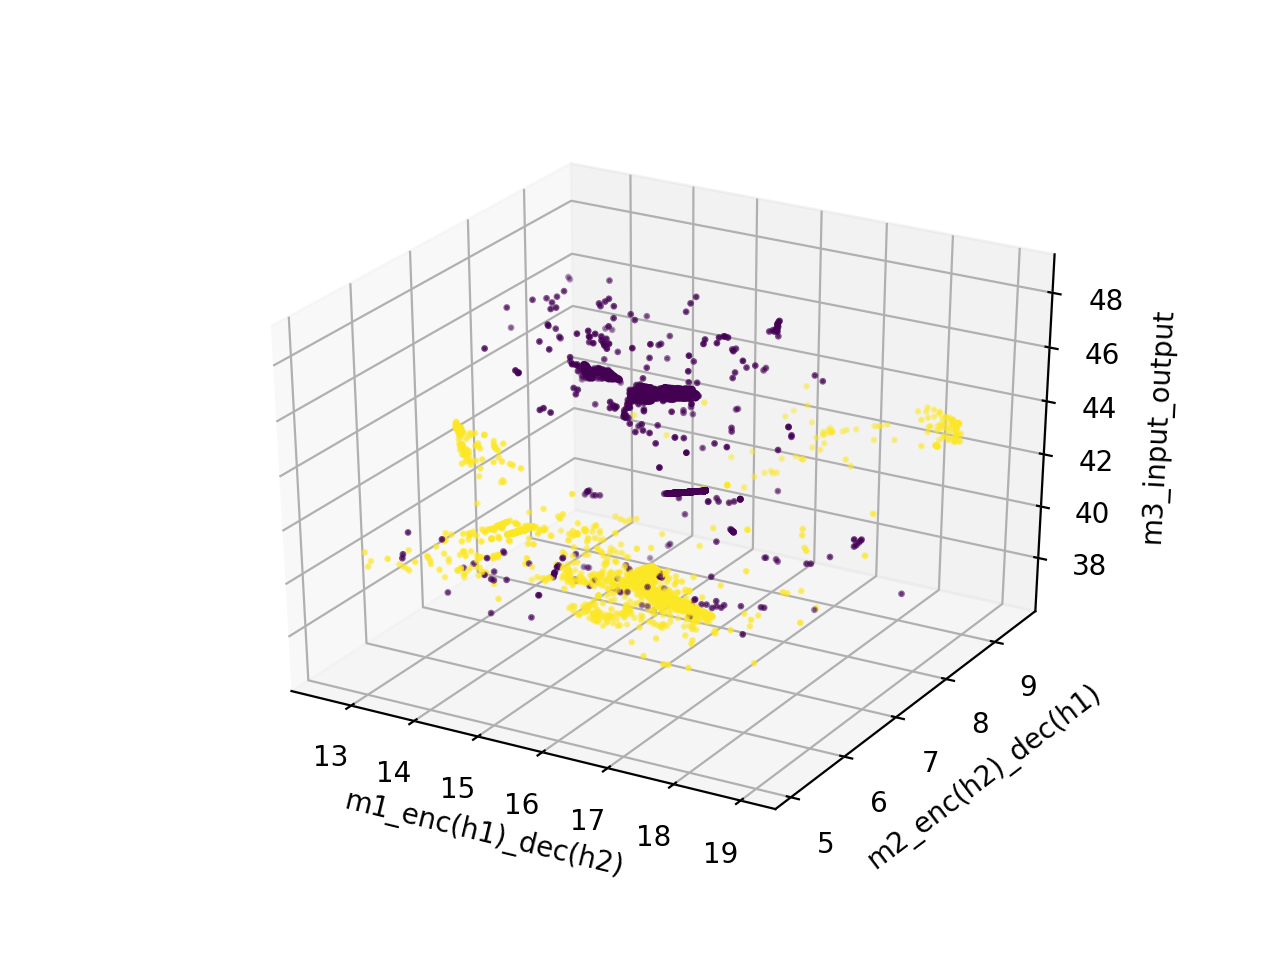

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c1,c2, c3, c=y_test.astype(int),s=2)
ax.set_xlabel('m1_enc(h1)_dec(h2)')
ax.set_ylabel('m2_enc(h2)_dec(h1)')
ax.set_zlabel('m3_input_output')
plt.show()